In [1]:
import os
import sys
import time
import io

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as tdata
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.notebook import tqdm
import wandb

In [2]:
from anime_face_generator.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR, FIGURES_DIR
import anime_face_generator.modeling.models.giga_unet_edited_ddpm_85M as Giga
from anime_face_generator.modeling.train import train_model

%load_ext autoreload
%autoreload 2

2025-08-11 16:31:15.580 | INFO     | anime_face_generator.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/anime_face_generator


![Algorithm1](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models_DDPM_trainig_inference_algorithm-1024x247.png)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("number of GPUs:", torch.cuda.device_count())

Using device: cuda
number of GPUs: 2


## Data augmentation

In [4]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=Giga.ModelParams.im_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = torchvision.datasets.ImageFolder(root=PROCESSED_DATA_DIR, transform=transformers, target_transform=None)

In [5]:
rand_gen = torch.Generator().manual_seed(1978)

## Unet Denoiser Architecture

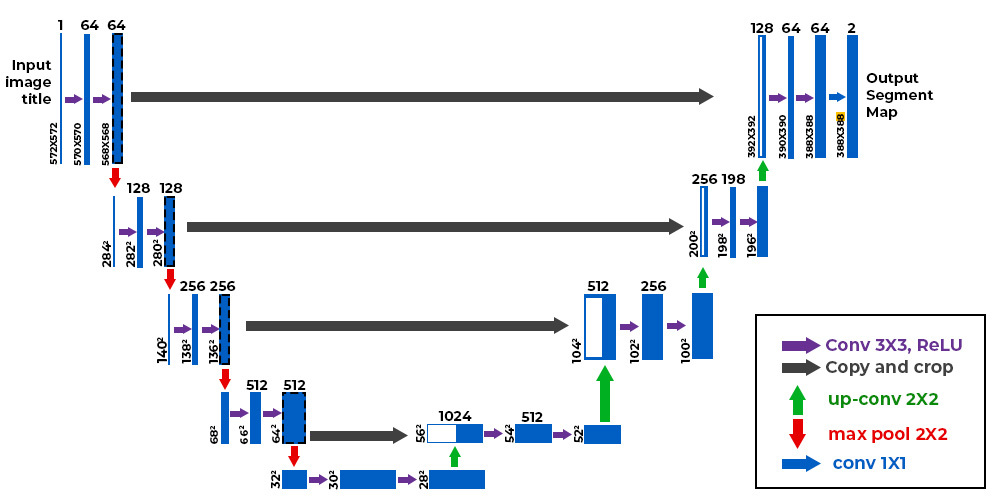

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ayoub-dev2000 (ayoub-dev2000-university-of-liege) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


---------------------------------------------
 EPOCH 10
---------------------------------------------
train loss: 0.039148  [    6/72454]
val loss: 0.025372  [    6/72454]
timestep in first x in the batch:  360


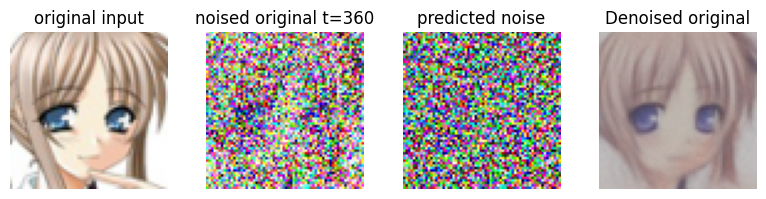

In [ ]:
model_backup = "85M_params_GIGA_DDPM_Unet_ckpt_epoch_9.pth"
giga_model_trained = train_model(module=Giga, dataset=dataset, device=device, rand_gen=rand_gen,
                                 model_backup=model_backup, epoch_start=10, step_start= 111085, wandb_logs=True)

## Simpling from the learned distribution

In [ ]:
model = Giga.NoisePredictor()
reverse_diffusion = model.diffuser.reverse


model_backup = "85M_params_GIGA_DDPM_Unet_ckpt_epoch_9.pth"
model.load_state_dict(torch.load(MODELS_DIR / model_backup, weights_only=True))

model = model.to(device)

num_model_params = model.get_num_trainable_parameters()
print(f"Number of trainable parameters: {num_model_params / 1e6:.2f}M")

In [ ]:
@torch.no_grad()
def generate(model, shape=(1, 3, 64, 64)):
    x = torch.randn(shape).to(device)
    B = shape[0]    #batch size, number of samples to generate
    # Generate samples by reversing the diffusion process
    for t_step in reversed(range(Giga.SchedulerConfig.T)):
        t = torch.full((B,), t_step, dtype=torch.long).to(x.device)
        pred_eps = model(x, t)
        x = reverse_diffusion(x, t, pred_eps)
    return x

In [ ]:
@torch.no_grad()
def generate_samples(model, num_samples=48, image_size=Giga.ModelParams.im_size):
    model.eval()
    samples = generate(model, shape=(num_samples, Giga.ModelParams.im_channels, *image_size))
    return samples

def show_images_grid_rgb(samples, nrow=8, ncol=6):
    fig, axes = plt.subplots(ncol, nrow, figsize=(nrow, ncol))
    samples = (samples + 1) / 2         # Rescale from [-1, 1] to [0, 1]
    samples = samples.clamp(0, 1).cpu() # Ensure valid pixel range
    samples = samples.permute(0, 2, 3, 1)  #(N, H, W, C) for plotting

    idx = 0
    for row in range(ncol):
        for col in range(nrow):
            if idx == samples.shape[0]:
                break
            axes[row, col].imshow(samples[idx])
            axes[row, col].axis('off')
            idx += 1
    plt.tight_layout()
    fig_name = model_backup[0:-4] + '.png'
    plt.savefig(FIGURES_DIR / fig_name, format='png')
    plt.show()
    

# samples = generate_samples(model, num_samples=16, image_size=Giga.ModelParams.im_size) 

In [ ]:
show_images_grid_rgb(samples, nrow=8, ncol=2)

 ### Saving the notebook.

In [ ]:
plt.save(model_backup, type='png')

In [ ]:
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')